In [2]:
!pip install s2sphere

In [34]:
from s2sphere import LatLng, CellId
import pandas as pd
import heapq

class Region:
    __slots__ = ('cell_id','level','indices')
    def __init__(self, cell_id, level, indices):
        self.cell_id = cell_id      # an s2sphere.CellId
        self.level   = level        # integer level
        self.indices = indices      # list of DataFrame indices
    def count(self): 
        return len(self.indices)
    def split(self, df, lat_col, lon_col):
        """Split into children at level+1 and group membership."""
        next_level = self.level + 1
        groups = {}
        for i in self.indices:
            lat, lon = df.at[i, lat_col], df.at[i, lon_col]
            cid = CellId.from_lat_lng(LatLng.from_degrees(lat, lon)) \
                         .parent(next_level)
            groups.setdefault(cid.id(), []).append(i)
        return [
            Region(CellId(child_id), next_level, idxs)
            for child_id, idxs in groups.items()
        ]

def build_planet_partitions(
    train_df: pd.DataFrame,
    lat_col: str = 'latitude',
    lon_col: str = 'longitude',
    t1: int = 10000,
    t2: int = 50
):
    """
    Performs PlaNet‐style adaptive partitioning on train_df,
    returns (labels, kept_regions):
      - labels: pd.Series of length train_df, with class 0…K-1 (or -1)
      - kept_regions: list of Region objects whose cells were kept (count >= t2)
    """
    # 1) Seed with level=0 roots
    root_ids = train_df.apply(
        lambda r: CellId
            .from_lat_lng(LatLng.from_degrees(r[lat_col], r[lon_col]))
            .parent(0)
            .id(),
        axis=1
    )
    roots = [
        Region(CellId(rid), 0, idxs.tolist())
        for rid, idxs in root_ids.groupby(root_ids).groups.items()
    ]

    # 2) Recursively split any region > t1

    # include cell_id.id() as a tie-breaker
    heap = [(-r.count(),  r.cell_id.id(),  r) for r in roots]
    heapq.heapify(heap)

    leaves = []
    while heap:
        negc, _, region = heapq.heappop(heap)
        if region.count() > t1:
            for child in region.split(train_df, lat_col, lon_col):
                # push with the same tuple structure
                heapq.heappush(heap, (-child.count(), child.cell_id.id(), child))
        else:
            leaves.append(region)

    # 3) Prune leaves < t2
    kept = [r for r in leaves if r.count() >= t2]

    # 4) Assign train labels
    train_labels = pd.Series(-1, index=train_df.index, dtype=int)
    for cls_idx, region in enumerate(kept):
        train_labels.loc[region.indices] = cls_idx

    return train_labels, kept

def assign_planet_labels(
    df: pd.DataFrame,
    regions: list,
    lat_col: str = 'latitude',
    lon_col: str = 'longitude',
) -> pd.Series:
    """
    Given any df and a list of kept Region objects (from build_planet_partitions),
    returns a pd.Series of –1 or 0…K-1 depending on which region each point falls into.
    """
    # Group regions by their level for faster lookup
    by_level = {}
    for cls_idx, reg in enumerate(regions):
        by_level.setdefault(reg.level, {})[reg.cell_id.id()] = cls_idx

    labels = pd.Series(-1, index=df.index, dtype=int)

    # For each unique level, compute all cell_ids in bulk and map
    for level, mapping in by_level.items():
        # compute cell_id.id() at this level for every point
        ids = df.apply(
            lambda r: CellId
                .from_lat_lng(LatLng.from_degrees(r[lat_col], r[lon_col]))
                .parent(level)
                .id(),
            axis=1
        )
        # map to class_idx (NaN becomes -1)
        mapped = ids.map(mapping).fillna(-1).astype(int)
        # only overwrite labels that are still -1
        mask = (labels == -1) & (mapped >= 0)
        labels.loc[mask] = mapped.loc[mask]

    return labels


In [35]:
import os

# --- set up paths ---
DATA_ROOT          = '/kaggle/input/osv-mini-129k/osv5m'
train_csv          = os.path.join(DATA_ROOT, 'train_mini.csv')
test_csv           = os.path.join(DATA_ROOT, 'test_mini.csv')
train_images_root  = os.path.join(DATA_ROOT, 'train_images')
test_images_root   = os.path.join(DATA_ROOT, 'test_images')

LABEL_COL = 'planet_class'

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# 1) Build partitions on train
train_labels, kept_regions = build_planet_partitions(
    train_df, lat_col='latitude', lon_col='longitude',
    t1=100, t2=20
)
train_df[LABEL_COL] = train_labels
train_df = train_df[train_labels >= 0].reset_index(drop=True)

# 2) Apply exactly same to test
test_labels = assign_planet_labels(
    test_df, kept_regions, lat_col='latitude', lon_col='longitude'
)
test_df[LABEL_COL] = test_labels
test_df = test_df[test_labels >= 0].reset_index(drop=True)


In [36]:
print(train_df[LABEL_COL].unique()[:5])
print(train_df[LABEL_COL].nunique())

[ 88 668 884 311 985]
2199


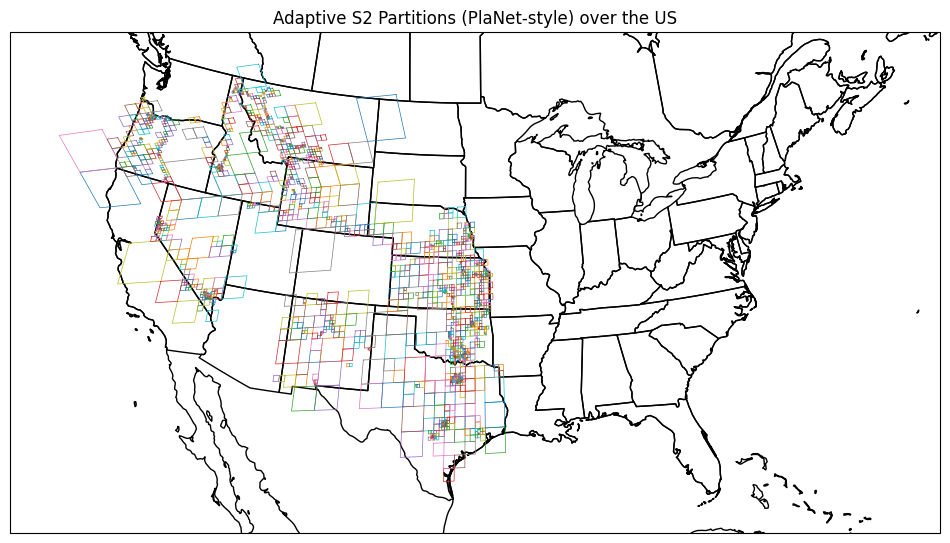

In [37]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from s2sphere import LatLng, CellId, Cell

# --- plot ---
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.add_feature(cfeature.STATES)

for region in kept_regions:
    cell = Cell(region.cell_id)
    # manually grab the 4 corners
    verts = [cell.get_vertex(i) for i in range(4)]
    lats = []
    lons = []
    for v in verts:
        ll = LatLng.from_point(v)
        lats.append(ll.lat().degrees)
        lons.append(ll.lng().degrees)
    # close the polygon
    lats.append(lats[0])
    lons.append(lons[0])
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), linewidth=0.5)

plt.title('Adaptive S2 Partitions (PlaNet‐style) over the US')
plt.show()

In [53]:
# import os
# import glob
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as T


# class GeoDataset(Dataset):
#     def __init__(self, df, images_root, transforms=None):
#         self.df = df[df[LABEL_COL] != -1].reset_index(drop=True)
#         self.nclasses = self.df[LABEL_COL].nunique()

#         # build a map from image‐ID → full path
#         all_files = glob.glob(os.path.join(images_root, '*', '*.jpg'))
#         self.id2path = {
#             os.path.splitext(os.path.basename(p))[0]: p
#             for p in all_files
#         }
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row    = self.df.iloc[idx]
#         img_id = str(row['id'])
#         label  = int(row[LABEL_COL])
#         img    = Image.open(self.id2path[img_id]).convert('RGB')
#         if self.transforms:
#             img = self.transforms(img)
#         return img, label





# # --- instantiate datasets ---
# train_ds = GeoDataset(
#     df      = train_df,
#     images_root  = train_images_root,
#     transforms   = T.Compose([
#         T.Resize((224,224)),
#         T.RandomHorizontalFlip(),
#         T.ToTensor(),
#         T.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
#     ])
# )

# test_ds = GeoDataset(
#     df     = test_df,
#     images_root  = test_images_root,
#     transforms   = T.Compose([
#         T.Resize((224,224)),
#         T.ToTensor(),
#         T.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
#     ])
# )

# print(f"Found {train_ds.nclasses} cells (classes) in train GeoDataset.")
# print(f"Found {test_ds.nclasses} cells (classes) in test GeoDataset.")
import os
import glob
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class GeoDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images_root: str,
        nclasses: int,
        label_col: str = 'planet_class',
        transforms=None
    ):
        # 1) keep only valid labels (>=0)
        self.df = df[df[label_col] >= 0].reset_index(drop=True)

        self.label_col = label_col
        self.classes = nclasses

        # 3) build a map from image‐ID → full path
        all_files = glob.glob(os.path.join(images_root, '*', '*.jpg'))
        self.id2path = {
            os.path.splitext(os.path.basename(p))[0]: p
            for p in all_files
        }

        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row    = self.df.iloc[idx]
        img_id = str(row['id'])
        label  = int(row[self.label_col])
        img    = Image.open(self.id2path[img_id]).convert('RGB')
        if self.transforms:
            img = self.transforms(img)
        return img, label

# --- instantiate ---
train_ds = GeoDataset(
    df          = train_df,
    images_root = train_images_root,
    label_col   = LABEL_COL,
    nclasses=len(kept_regions),
    transforms  = T.Compose([
        T.Resize((224,224)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
    ])
)

test_ds = GeoDataset(
    df          = test_df,
    images_root = test_images_root,
    label_col   = LABEL_COL,
    nclasses=len(kept_regions),
    transforms  = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
    ])
)

print(f"Softmax size (num classes) = {train_ds.classes}")  # same for both


Softmax size (num classes) = 2199


In [44]:
len(kept_regions)

2199

In [54]:
from torch.utils.data import random_split, DataLoader
import torch

# total size of the full training dataset
num_train = len(train_ds)
# 20% for validation
num_val   = int(0.1 * num_train)
# the rest for (re‑defined) training
num_train_new = num_train - num_val

batch_size  = 64

# split with a fixed seed so it’s reproducible
train_subset, val_subset = random_split(
    train_ds,
    [num_train_new, num_val],
    generator=torch.Generator().manual_seed(42)
)

# now wrap each in its own DataLoader
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,   # no need to shuffle validation
    num_workers=4
)

test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train on {len(train_subset)} images, validate on {len(val_subset)} images.")

Train on 101296 images, validate on 11255 images.


In [55]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [57]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm

# --- 1) Configuration ---------------------------------------------------------
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = train_ds.classes       # from your GeoDataset
epochs_stage1 = 1    # head only
epochs_stage2 = 10   # head + layer4
epochs_stage3 = 5    # full fine‑tune (optional)

# --- 2) Model setup ----------------------------------------------------------
# 2.1 Load a pre‑trained backbone
model = models.resnet50(pretrained=True)

# 2.2 Replace the final FC head
in_feats      = model.fc.in_features
model.fc      = nn.Linear(in_feats, num_classes)
model          = model.to(device)

# --- 3) Utility functions ----------------------------------------------------
def set_parameter_requires_grad(model, freeze_until=None):
    """
    If freeze_until is None: freeze everything except model.fc
    If freeze_until == 'layer4': unfreeze layer4 + fc, freeze earlier
    If freeze_until == 'all': unfreeze everything
    """
    if freeze_until is None:
        # freeze all conv layers
        for name, param in model.named_parameters():
            if not name.startswith("fc."):
                param.requires_grad = False
    elif freeze_until == "layer4":
        for name, param in model.named_parameters():
            # unfreeze layer4 and fc
            if name.startswith("layer4.") or name.startswith("fc."):
                param.requires_grad = True
            else:
                param.requires_grad = False
    elif freeze_until == "all":
        for param in model.parameters():
            param.requires_grad = True

def make_optimizer(model, lr):
    # only parameters with requires_grad=True will be optimized
    params = [p for p in model.parameters() if p.requires_grad]
    return optim.AdamW(params, lr=lr, weight_decay=1e-4)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    i = 0
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss   += loss.item() * imgs.size(0)
        preds         = out.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total        += imgs.size(0)

        # if i % 2000 == 0:
        #     print("Finished image", i)
        # i += 1

    avg_loss = total_loss / total
    acc      = total_correct / total
    return avg_loss, acc

def validate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            total_loss   += loss.item() * imgs.size(0)
            preds         = out.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total        += imgs.size(0)

    avg_loss = total_loss / total
    acc      = total_correct / total
    return avg_loss, acc



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s] 


In [58]:
# --- 4) Training loop ---------------------------------------------------------
criterion = nn.CrossEntropyLoss()

# --- Stage 1: train head only ---
set_parameter_requires_grad(model, freeze_until=None)
opt = make_optimizer(model, lr=1e-3)
sched = lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)

for epoch in range(epochs_stage1):
    tl, ta = train_one_epoch(model, train_loader, criterion, opt)
    vl, va = validate(model, val_loader,   criterion)
    sched.step()
    print(f"[S1][E{epoch+1}/{epochs_stage1}]  train: {tl:.4f}/{ta:.3f}  val: {vl:.4f}/{va:.3f}")



  0%|          | 0/1583 [00:00<?, ?it/s]

[S1][E1/1]  train: 5.8064/0.150  val: 4.5427/0.247


In [ ]:
# --- Stage 2: unfreeze last block (layer4) + head ---
set_parameter_requires_grad(model, freeze_until="layer4")
opt = make_optimizer(model, lr=1e-4)
sched = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

for epoch in range(epochs_stage2):
    tl, ta = train_one_epoch(model, train_loader, criterion, opt)
    vl, va = validate(model, val_loader,   criterion)
    sched.step()
    print(f"[S2][E{epoch+1}/{epochs_stage2}]  train: {tl:.4f}/{ta:.3f}  val: {vl:.4f}/{va:.3f}")




In [6]:
# --- Stage 3: optional full fine‑tuning (low LR) ---
set_parameter_requires_grad(model, freeze_until="all")
opt = make_optimizer(model, lr=1e-5)
sched = lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)

for epoch in range(epochs_stage3):
    tl, ta = train_one_epoch(model, train_loader, criterion, opt)
    vl, va = validate(model, val_loader,   criterion)
    sched.step()
    print(f"[S3][E{epoch+1}/{epochs_stage3}]  train: {tl:.4f}/{ta:.3f}  val: {vl:.4f}/{va:.3f}")



NameError: name 'criterion' is not defined

In [59]:
# --- 5) Test-set evaluation (once you’re happy) -------------------------------
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test set →  loss: {test_loss:.4f}, acc: {test_acc:.3f}")

Test set →  loss: 6.7724, acc: 0.133


In [7]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

def compute_occlusion_map(
    model,
    image,            # a single tensor C×H×W, already normalized
    label,            # the ground‐truth int label for this image
    patch_size=32,    # occluder width/height in pixels
    stride=16,        # how many pixels to slide each step
    occlusion_value=0 # fill value after normalization (0 → dataset mean)
):
    model.eval()
    device = next(model.parameters()).device
    image = image.to(device)

    # 1) baseline probability for the true class
    with torch.no_grad():
        out  = model(image.unsqueeze(0))
        p0   = F.softmax(out, dim=1)[0, label].item()

    _, H, W = image.shape
    n_rows  = (H - patch_size)//stride + 1
    n_cols  = (W - patch_size)//stride + 1

    heatmap = torch.zeros((n_rows, n_cols), device=device)

    # 2) slide the occluder
    for i in range(n_rows):
        for j in range(n_cols):
            top, left = i*stride, j*stride
            occ_img = image.clone()
            occ_img[:, top:top+patch_size, left:left+patch_size] = occlusion_value

            with torch.no_grad():
                out_ij = model(occ_img.unsqueeze(0))
                prob  = F.softmax(out_ij, dim=1)[0, label].item()

            # continuous drop in probability:
            heatmap[i, j] = p0 - prob

            # — if you’d rather have a binary “accuracy‐based” map, replace the
            #   two lines above with something like:
            #     correct0 = (out.argmax(1) == label).float()
            #     correct_ij = (out_ij.argmax(1) == label).float()
            #     heatmap[i,j] = (correct0 - correct_ij).item()

    # 3) upsample back to full image size
    heatmap = heatmap.unsqueeze(0).unsqueeze(0)  # 1×1×n_rows×n_cols
    heatmap = F.interpolate(heatmap, size=(H, W), mode='bilinear', align_corners=False)
    return heatmap.squeeze().cpu().numpy()  # H×W float array


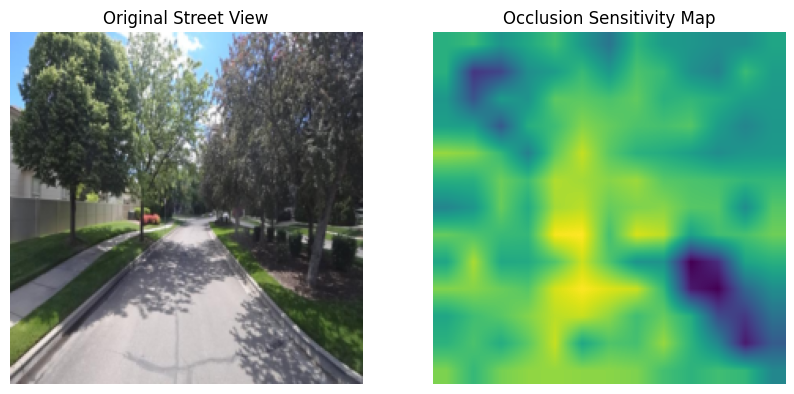

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def compute_occlusion_map(
    model,
    image,            # C×H×W tensor, already normalized
    label,            # true‐class int
    patch_size=32,
    stride=16,
    occlusion_value=0
):
    model.eval()
    device = next(model.parameters()).device
    image = image.to(device)
    with torch.no_grad():
        out = model(image.unsqueeze(0))
        p0  = F.softmax(out, dim=1)[0, label].item()

    _, H, W  = image.shape
    n_rows   = (H - patch_size)//stride + 1
    n_cols   = (W - patch_size)//stride + 1
    heatmap  = torch.zeros((n_rows, n_cols), device=device)

    for i in range(n_rows):
        for j in range(n_cols):
            top, left = i*stride, j*stride
            occ = image.clone()
            occ[:, top:top+patch_size, left:left+patch_size] = occlusion_value
            with torch.no_grad():
                out_ij = model(occ.unsqueeze(0))
                prob   = F.softmax(out_ij, dim=1)[0, label].item()
            heatmap[i, j] = p0 - prob

    heatmap = heatmap.unsqueeze(0).unsqueeze(0)
    heatmap = F.interpolate(heatmap, size=(H, W), mode='bilinear', align_corners=False)
    return heatmap.squeeze().cpu().numpy()

# Grab one sample
imgs, labels = next(iter(val_loader))
img, label   = imgs[0], labels[0].item()

# Unnormalize for display
mean = torch.tensor([.485, .456, .406]).view(3,1,1)
std  = torch.tensor([.229, .224, .225]).view(3,1,1)
img_disp = img * std + mean
img_np   = np.transpose(img_disp.numpy(), (1,2,0))

# Compute occlusion map
heatmap = compute_occlusion_map(model, img, label, patch_size=32, stride=16, occlusion_value=0)

# Plot side‐by‐side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Original image
ax1.imshow(img_np)
ax1.axis('off')
ax1.set_title('Original Street View')

# Heatmap
im = ax2.imshow(heatmap, cmap='viridis')
ax2.axis('off')
ax2.set_title('Occlusion Sensitivity Map')

# Colorbar
cbar = fig


In [1]:
import pandas as pd
import os

DATA_ROOT          = '/kaggle/input/osv-mini-129k/osv5m'
train_csv          = os.path.join(DATA_ROOT, 'train_mini.csv')
df = pd.read_csv(train_csv)
df.head()

,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,quadtree_10_50000,quadtree_10_12500,quadtree_10_500,quadtree_10_2500,unique_region,unique_sub-region,unique_city,unique_country,creator_username,creator_id
0,175846147796767,31.807977,-109.051129,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743210350,18.0,64.0,"(18, 64)",...,58,238,3570,1186,New Mexico_US,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14
1,327253605472404,31.805039,-109.053170,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743197630,18.0,64.0,"(18, 64)",...,58,238,3570,1186,New Mexico_US,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14
2,4079391105448884,31.795616,-109.059784,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743526750,18.0,64.0,"(18, 64)",...,58,238,3570,1186,New Mexico_US,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14
3,815733012693812,31.839720,-109.029062,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,crag9qhk6sw89qnqvs1v0p,1460300841441,18.0,64.0,"(18, 64)",...,58,238,3570,1186,New Mexico_US,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14
4,471207127297520,31.812350,-109.048174,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743448990,18.0,64.0,"(18, 64)",...,58,238,3570,1186,New Mexico_US,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14


In [2]:
print(type(df['cell'][0]))

<class 'str'>


In [3]:
# define the cell you want
target_cell = "(18, 64)"

# filter the DataFrame
df_onecell = df[df["cell"] == target_cell]

print(df_onecell.shape)
print(df_onecell["cell"].unique())

(221, 32)
['(18, 64)']


/tmp/ipykernel_31/240776519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_onecell['latitude']  = df_onecell['latitude'].astype(float)
/tmp/ipykernel_31/240776519.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_onecell['longitude'] = df_onecell['longitude'].astype(float)


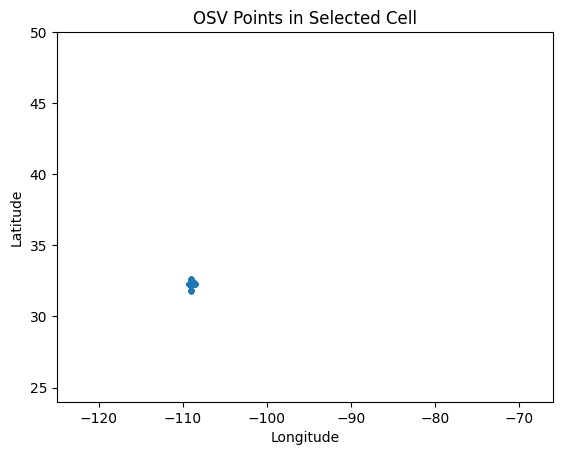

In [4]:
import matplotlib.pyplot as plt

# Ensure numeric types
df_onecell['latitude']  = df_onecell['latitude'].astype(float)
df_onecell['longitude'] = df_onecell['longitude'].astype(float)

# Create the plot
fig, ax = plt.subplots()
ax.scatter(df_onecell['longitude'], df_onecell['latitude'], s=10)
ax.set_xlim(-125, -66)    # continental US longitudes
ax.set_ylim(24, 50)       # continental US latitudes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('OSV Points in Selected Cell')
plt.show()


In [5]:
import numpy as np

# 1. Pull out the extremes
lat_min = df_onecell['latitude'].min()
lat_max = df_onecell['latitude'].max()
lon_min = df_onecell['longitude'].min()
lon_max = df_onecell['longitude'].max()

# 2. Haversine function (returns meters)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    φ1, φ2 = np.radians(lat1), np.radians(lat2)
    Δφ    = np.radians(lat2 - lat1)
    Δλ    = np.radians(lon2 - lon1)

    a = np.sin(Δφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(Δλ/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# 3. Compute spans
# East–West span at the midpoint latitude
lat_mid = (lat_min + lat_max) / 2
ew_dist = haversine(lat_mid, lon_min, lat_mid, lon_max)

# North–South span at the midpoint longitude
lon_mid = (lon_min + lon_max) / 2
ns_dist = haversine(lat_min, lon_mid, lat_max, lon_mid)

print(f"East–West span:  {ew_dist:.1f} m")
print(f"North–South span:{ns_dist:.1f} m")


East–West span:  62568.3 m
North–South span:95263.8 m


In [6]:
def max_spans(df):
    # ensure numeric lat/lon
    df = df.copy()
    df['latitude']  = df['latitude'].astype(float)
    df['longitude'] = df['longitude'].astype(float)

    ew_spans = []
    ns_spans = []
    for _, group in df.groupby('cell'):
        lat_min, lat_max = group['latitude'].min(), group['latitude'].max()
        lon_min, lon_max = group['longitude'].min(), group['longitude'].max()
        lat_mid = (lat_min + lat_max) / 2
        lon_mid = (lon_min + lon_max) / 2

        ew_spans.append( haversine(lat_mid, lon_min,  lat_mid, lon_max) )
        ns_spans.append( haversine(lat_min, lon_mid,  lat_max, lon_mid) )

    return max(ew_spans), max(ns_spans)

In [7]:
max_ew, max_ns = max_spans(df)
print(f"Max east–west span across cells:  {max_ew:.1f} m")
print(f"Max north–south span across cells: {max_ns:.1f} m")

Max east–west span across cells:  346417.5 m
Max north–south span across cells: 149969.5 m


In [9]:
print(df['lon_bin'].min(), df['lon_bin'].max())
print(df['lat_bin'].min(), df['lat_bin'].max())

14.0 23.0
60.0 77.0


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


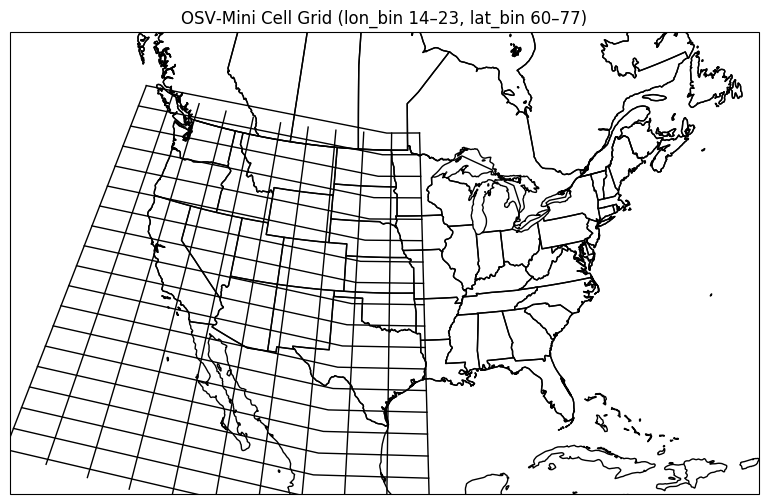

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Specify your bin index range
lon_bin_min, lon_bin_max = 14, 23
lat_bin_min, lat_bin_max = 60, 77

# 2. Compute degree‐per‐bin
d_lon = 360.0 / 100  # = 3.6°
d_lat = 180.0 / 100  # = 1.8°

# 3. Build the edge arrays (include the final edge at +1 index)
lon_edges = -180 + np.arange(lon_bin_min, lon_bin_max + 2) * d_lon
lat_edges = -90  + np.arange(lat_bin_min, lat_bin_max + 2) * d_lat

# 4. Set up the map
fig = plt.figure(figsize=(10, 6))
ax  = plt.axes(projection=ccrs.LambertConformal())
# Clip to continental US
ax.set_extent([-130, -65, 20, 55], ccrs.PlateCarree())

# Add states, coastlines, borders
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# 5. Overlay vertical (constant‐lon) lines
for lon in lon_edges:
    ax.plot([lon, lon], [lat_edges[0], lat_edges[-1]],
            transform=ccrs.PlateCarree(),
            linewidth=1, color='black')

# 6. Overlay horizontal (constant‐lat) lines
for lat in lat_edges:
    ax.plot([lon_edges[0], lon_edges[-1]], [lat, lat],
            transform=ccrs.PlateCarree(),
            linewidth=1, color='black')

ax.set_title('OSV‑Mini Cell Grid (lon_bin 14–23, lat_bin 60–77)')
plt.show()


In [11]:
df['cell'].unique()

array(['(18, 64)', '(19, 64)', '(20, 64)', '(19, 65)', '(18, 65)',
       '(19, 66)', '(20, 65)', '(20, 66)', '(18, 66)', '(18, 67)',
       '(19, 67)', '(20, 67)', '(18, 68)', '(19, 68)', '(21, 66)',
       '(20, 68)', '(21, 67)', '(22, 65)', '(22, 66)', '(22, 67)',
       '(22, 68)', '(18, 70)', '(18, 71)', '(16, 72)', '(17, 71)',
       '(17, 72)', '(18, 72)', '(16, 73)', '(16, 74)', '(17, 73)',
       '(18, 73)', '(17, 74)', '(18, 74)', '(19, 71)', '(20, 71)',
       '(20, 70)', '(21, 70)', '(21, 71)', '(22, 70)', '(22, 71)',
       '(19, 72)', '(21, 72)', '(20, 72)', '(19, 73)', '(19, 74)',
       '(20, 74)', '(20, 73)', '(22, 72)', '(16, 75)', '(17, 75)',
       '(18, 75)', '(16, 76)', '(17, 76)', '(18, 76)', '(17, 77)',
       '(18, 77)', '(19, 75)', '(20, 75)', '(19, 76)', '(22, 63)',
       '(21, 63)', '(21, 62)', '(22, 62)', '(22, 64)', '(21, 64)',
       '(23, 65)', '(22, 61)', '(21, 65)', '(20, 62)', '(21, 61)',
       '(23, 64)', '(23, 63)', '(19, 63)', '(20, 63)', '(23, 6

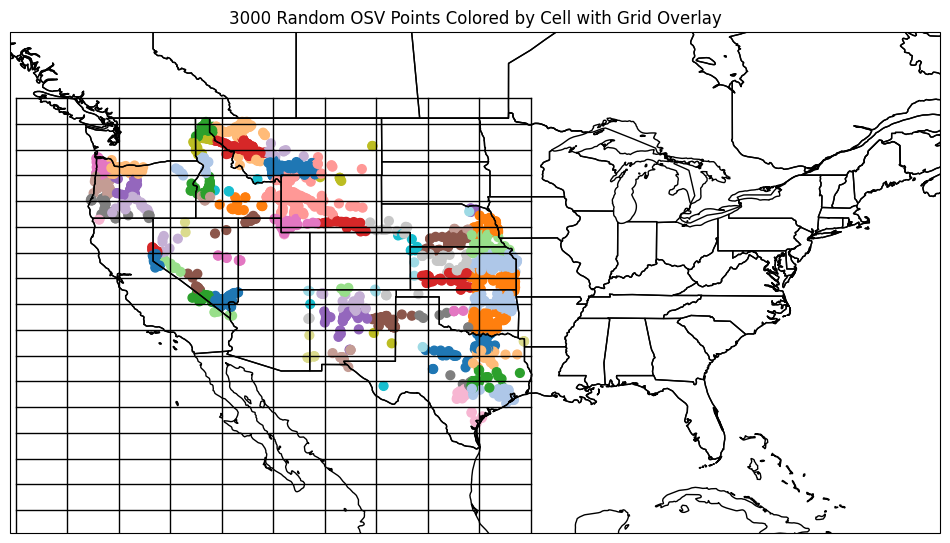

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

n=3000

# --- Sampling 100 random points and preparing color codes ---
sample = df.sample(n=n, random_state=42).copy()
sample['latitude']  = sample['latitude'].astype(float)
sample['longitude'] = sample['longitude'].astype(float)
codes, _ = pd.factorize(sample['cell'])

# --- Define bin ranges (from your data) ---
lon_bin_min, lon_bin_max = 14, 23
lat_bin_min, lat_bin_max = 60, 77
d_lon = 360.0 / 100  # degrees per lon_bin
d_lat = 180.0 / 100  # degrees per lat_bin

# Compute the grid‐line edges
lon_edges = -180 + np.arange(lon_bin_min, lon_bin_max + 2) * d_lon
lat_edges =  -90 + np.arange(lat_bin_min, lat_bin_max + 2) * d_lat

# --- Create the map ---
fig, ax = plt.subplots(
    figsize=(12, 7),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent([-130, -65, 20, 55], ccrs.PlateCarree())

# Add US geography
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# --- Plot the sampled points, colored by cell ---
ax.scatter(
    sample['longitude'], sample['latitude'],
    c=codes, cmap='tab20', s=40,
    transform=ccrs.PlateCarree(),
    zorder=1
)

# --- Draw grid lines on top ---
for lon in lon_edges:
    ax.plot(
        [lon, lon], [lat_edges[0], lat_edges[-1]],
        transform=ccrs.PlateCarree(),
        linewidth=1, color='black', zorder=2
    )
for lat in lat_edges:
    ax.plot(
        [lon_edges[0], lon_edges[-1]], [lat, lat],
        transform=ccrs.PlateCarree(),
        linewidth=1, color='black', zorder=2
    )

ax.set_title(f'{n} Random OSV Points Colored by Cell with Grid Overlay')
plt.show()


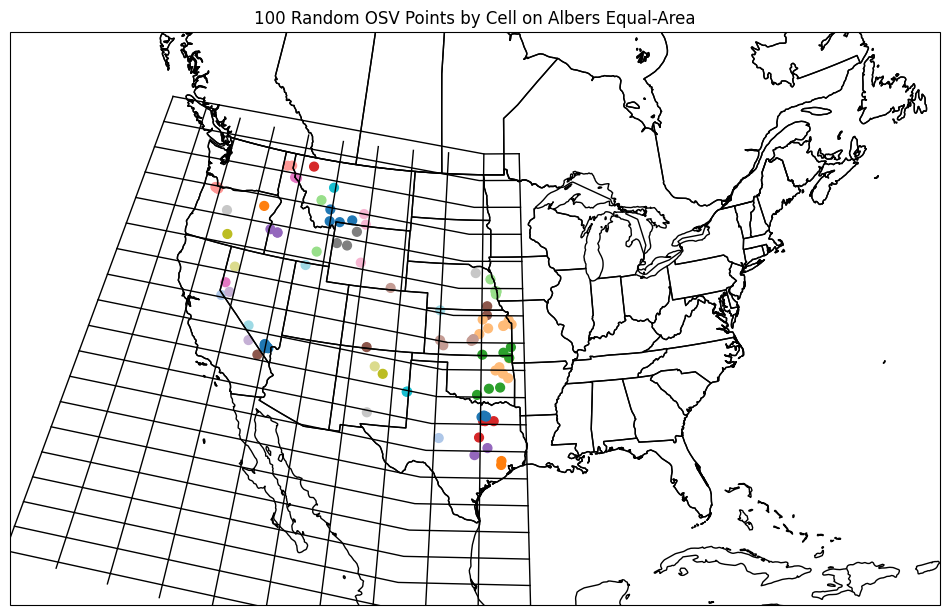

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# --- Sample and color-code 100 points ---
sample = df.sample(n=100, random_state=42).copy()
sample['latitude']  = sample['latitude'].astype(float)
sample['longitude'] = sample['longitude'].astype(float)
codes, _ = pd.factorize(sample['cell'])

# --- Compute grid-edge arrays ---
lon_bin_min, lon_bin_max = 14, 23
lat_bin_min, lat_bin_max = 60, 77
d_lon = 360.0 / 100
d_lat = 180.0 / 100

lon_edges = -180 + np.arange(lon_bin_min, lon_bin_max + 2) * d_lon
lat_edges =  -90 + np.arange(lat_bin_min, lat_bin_max + 2) * d_lat

# --- Plot on Albers Equal-Area ---
proj = ccrs.AlbersEqualArea(
    central_longitude=-96, central_latitude=37.5,
    standard_parallels=(29.5, 45.5)
)
fig, ax = plt.subplots(
    figsize=(12,8),
    subplot_kw={'projection': proj}
)
# Limit to continental US
ax.set_extent([-130, -65, 20, 55], crs=ccrs.PlateCarree())

# Draw geography
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# Scatter points (zorder=1)
ax.scatter(
    sample['longitude'], sample['latitude'],
    c=codes, cmap='tab20', s=40,
    transform=ccrs.PlateCarree(), zorder=1
)

# Overlay grid lines on top (zorder=2)
for lon in lon_edges:
    ax.plot([lon, lon], [lat_edges[0], lat_edges[-1]],
            transform=ccrs.PlateCarree(),
            linewidth=1, color='black', zorder=2)
for lat in lat_edges:
    ax.plot([lon_edges[0], lon_edges[-1]], [lat, lat],
            transform=ccrs.PlateCarree(),
            linewidth=1, color='black', zorder=2)

ax.set_title('100 Random OSV Points by Cell on Albers Equal‐Area')
plt.show()
